In [1]:
import nltk
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import reuters, stopwords
from nltk.stem import PorterStemmer
from tensorflow.keras.utils import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
import json

# Download NLTK resources
nltk.download('reuters')
nltk.download('stopwords')

class UnifiedTokenizer:
    def __init__(self, stop_words, min_length=4, use_stemming=False):
        self.stop_words = stop_words
        self.min_length = min_length
        self.use_stemming = use_stemming
        self.stemmer = PorterStemmer() if use_stemming else None

    def tokenize(self, text):
        text = text.lower()  # Lowercase
        text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)  # Remove punctuation
        text = re.sub(r'\d+', '', text)  # Remove numbers
        tokens = text.split()  # Split into tokens
        tokens = [
            self.stemmer.stem(word) if self.use_stemming else word
            for word in tokens
            if word not in self.stop_words and len(word) >= self.min_length
        ]
        return tokens

class ReutersPreprocessor:
    def __init__(self, tokenizer, max_features=10000, max_sequence_length=500):
        self.tokenizer = tokenizer
        self.max_features = max_features
        self.max_sequence_length = max_sequence_length
        self.vocabulary = {}

    def _build_vocabulary(self, texts):
        word_counts = {}
        for tokens in texts:
            for token in tokens:
                word_counts[token] = word_counts.get(token, 0) + 1
        sorted_vocab = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        self.vocabulary = {word: idx + 1 for idx, (word, _) in enumerate(sorted_vocab[:self.max_features])}
        print(f"Vocabulary size: {len(self.vocabulary)}")

    def preprocess(self):
        documents = reuters.fileids()
        texts = [reuters.raw(doc_id) for doc_id in documents]
        labels = [reuters.categories(doc_id) for doc_id in documents]

        data = pd.DataFrame({'document_id': documents, 'text': texts, 'labels': labels})
        multi_label_data = data[data['labels'].apply(len) > 1]
        print(f"Number of multi-label articles: {len(multi_label_data)}")

        multi_label_data.loc[:, 'tokens'] = multi_label_data['text'].apply(self.tokenizer.tokenize)
        self._build_vocabulary(multi_label_data['tokens'])

        sequences = multi_label_data['tokens'].apply(lambda x: [self.vocabulary.get(token, 0) for token in x])
        X = pad_sequences(sequences.tolist(), maxlen=self.max_sequence_length, padding='post')

        mlb = MultiLabelBinarizer()
        y = mlb.fit_transform(multi_label_data['labels'])

        # Save tokenized texts, vocabulary, and labels
        with open("tokenized_texts.json", "w") as f:
            json.dump(multi_label_data['tokens'].tolist(), f)
        np.save("X.npy", X)
        np.save("y.npy", y)
        np.save("vocabulary.npy", self.vocabulary)
        np.save("class_labels.npy", mlb.classes_)

        print("Preprocessing complete. Data saved.")
        return X, y, self.vocabulary, mlb.classes_

# Initialize tokenizer and preprocessor
if __name__ == "__main__":
    stop_words = set(stopwords.words('english')) | {"reuters", "news"}
    tokenizer = UnifiedTokenizer(stop_words=stop_words, min_length=4, use_stemming=True)
    preprocessor = ReutersPreprocessor(tokenizer=tokenizer)
    X, y, vocabulary, class_labels = preprocessor.preprocess()

2024-11-26 12:08:50.449573: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package reuters to
[nltk_data]     /Users/colinwilkie/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/colinwilkie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Number of multi-label articles: 1628
Vocabulary size: 7729
Preprocessing complete. Data saved.


/var/folders/yh/l_t10td97zbcx6stbhn0_w_00000gn/T/ipykernel_22439/2550981447.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_label_data.loc[:, 'tokens'] = multi_label_data['text'].apply(self.tokenizer.tokenize)


In [2]:
# Reload tokenized texts
with open("tokenized_texts.json", "r") as f:
    tokenized_texts = json.load(f)

# Reload original labels
original_labels = np.load("y.npy", allow_pickle=True)

# Define domain-specific keywords
domain_keywords = {
    # Agriculture-related categories
    "agriculture": [
        "wheat", "corn", "grain", "soybean", "crop", "harvest", "farming", "rice", "barley",
        "sorghum", "cotton", "plantation", "livestock", "oilseed"
    ],
    
    # Energy-related categories
    "energy": [
        "oil", "gas", "fuel", "crude", "barrel", "bpd", "petroleum", "energy", "prices", 
        "production", "reserves"
    ],
    
    # Finance-related categories
    "finance": [
        "market", "stock", "shares", "investment", "economy", "profit", "trade", "money",
        "currency", "rates"
    ],
    
    # Commodities and metals
    "commodities": [
        "gold", "silver", "copper", "tin", "aluminium", "zinc", "platinum", "nickel", 
        "palladium", "strategic-metal"
    ],
    
    # Trade-related categories
    "trade": [
        "exports", "imports", "tariff", "agreement", "deficit", "surplus", "shipment", 
        "commerce", "international", "global"
    ],
    
    # Other categories
    "livestock": ["beef", "pork", "cattle", "hog", "meat", "slaughter"],
    "retail": ["retail", "sales", "growth", "consumer", "earnings", "income"],
    "environment": ["climate", "carbon", "sustainability", "pollution", "green", "renewable"],
}

# Add domain-specific labels
def add_domain_labels(tokenized_texts, domain_keywords):
    updated_labels = []
    for tokens in tokenized_texts:
        labels = []
        for label, keywords in domain_keywords.items():
            if any(keyword in tokens for keyword in keywords):
                labels.append(label)
        updated_labels.append(labels)
    return updated_labels

updated_labels = add_domain_labels(tokenized_texts, domain_keywords)
print("Domain-specific labels added.")

Domain-specific labels added.


In [3]:
# Combine original and domain-specific labels
combined_labels = [
    list(set(orig_labels + new_labels))  # Combine and remove duplicates
    for orig_labels, new_labels in zip(original_labels.tolist(), updated_labels)
]

# Save combined labels as JSON
with open("combined_labels.json", "w") as f:
    json.dump(combined_labels, f)

print("Combined labels saved as JSON.")

Combined labels saved as JSON.


In [4]:
# Reload combined labels
with open("combined_labels.json", "r") as f:
    combined_labels = json.load(f)

print(f"Loaded {len(combined_labels)} combined labels.")

Loaded 1628 combined labels.


In [5]:
# Load tokenized texts
with open("tokenized_texts.json", "r") as file:
    tokenized_texts = json.load(file)

# Load original labels
original_labels = np.load("y.npy", allow_pickle=True)

# Load combined labels
with open("combined_labels.json", "r") as file:
    combined_labels = json.load(file)

# Display a few examples
for i, (tokens, orig_labels, combined) in enumerate(zip(tokenized_texts[:5], original_labels[:5], combined_labels[:5])):
    print(f"Text {i + 1} Tokens: {tokens[:10]}...")  # Show first 10 tokens for brevity
    print(f"Original Labels: {orig_labels}")
    print(f"Combined Labels: {combined}\n")

Text 1 Tokens: ['japan', 'revis', 'long', 'term', 'energi', 'demand', 'downward', 'ministri', 'intern', 'trade']...
Original Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Combined Labels: [0, 1, 'finance']

Text 2 Tokens: ['thai', 'trade', 'deficit', 'widen', 'first', 'quarter', 'thailand', 'trade', 'deficit', 'widen']...
Original Labels: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 1 1 0 0 0 0 0]
Combined Labels: [0, 1, 'agriculture', 'retail', 'finance', 'trade']

Text 3 Tokens: ['indonesia', 'see', 'price', 'rise', 'sharpli', 'indonesia', 'expect', 'crude', 'palm', 'price']...
Original Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 

In [6]:
# Count articles with more than one label
multi_label_count = sum(len(labels) > 1 for labels in combined_labels)

# Print the result
print(f"Number of articles with more than one label: {multi_label_count}")

Number of articles with more than one label: 1628


In [7]:
for i in range(10):  # Check first 10 articles
    print(f"Original Labels: {original_labels[i]}")
    print(f"Combined Labels: {combined_labels[i]}")
    print()

Original Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Combined Labels: [0, 1, 'finance']

Original Labels: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 1 1 0 0 0 0 0]
Combined Labels: [0, 1, 'agriculture', 'retail', 'finance', 'trade']

Original Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
Combined Labels: [0, 1, 'agriculture', 'energy', 'finance']

Original Labels: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
Combined Labels: [0, 1, 'finance', 'energy']


In [8]:
augmented_count = sum(len(combined) > len(orig) for orig, combined in zip(original_labels, combined_labels))
print(f"Number of articles with augmented labels: {augmented_count}")

Number of articles with augmented labels: 0


In [9]:
# Test domain matching
for tokens in tokenized_texts[:10]:
    print(f"Tokens: {tokens[:10]}")
    for label, keywords in domain_keywords.items():
        matching_keywords = [keyword for keyword in keywords if keyword in tokens]
        if matching_keywords:
            print(f"Matched keywords for label '{label}': {matching_keywords}")
    print()

Tokens: ['japan', 'revis', 'long', 'term', 'energi', 'demand', 'downward', 'ministri', 'intern', 'trade']
Matched keywords for label 'finance': ['trade']

Tokens: ['thai', 'trade', 'deficit', 'widen', 'first', 'quarter', 'thailand', 'trade', 'deficit', 'widen']
Matched keywords for label 'agriculture': ['rice']
Matched keywords for label 'finance': ['trade']
Matched keywords for label 'trade': ['deficit']
Matched keywords for label 'retail': ['growth']

Tokens: ['indonesia', 'see', 'price', 'rise', 'sharpli', 'indonesia', 'expect', 'crude', 'palm', 'price']
Matched keywords for label 'agriculture': ['crop']
Matched keywords for label 'energy': ['crude']
Matched keywords for label 'finance': ['market']

Tokens: ['indonesian', 'commod', 'exchang', 'expand', 'indonesian', 'commod', 'exchang', 'like', 'start', 'trade']
Matched keywords for label 'energy': ['crude']
Matched keywords for label 'finance': ['market', 'trade']

Tokens: ['lanka', 'get', 'usda', 'approv', 'wheat', 'price', 'food'

In [10]:
combined_labels = [
    list(set(orig_labels + new_labels))  # Combine original and domain-specific labels, remove duplicates
    for orig_labels, new_labels in zip(original_labels.tolist(), updated_labels)
]

In [11]:
num_augmented_multi_label_articles = sum(len(labels) > 1 for labels in combined_labels)
print(f"Number of articles with more than one label after augmentation: {num_augmented_multi_label_articles}")

Number of articles with more than one label after augmentation: 1628


In [12]:
for i, (tokens, orig_labels, updated, combined) in enumerate(zip(tokenized_texts[:5], original_labels[:5], updated_labels[:5], combined_labels[:5])):
    print(f"Text {i + 1} Tokens: {tokens[:10]}...")
    print(f"Original Labels: {orig_labels}")
    print(f"Domain-Specific Labels: {updated}")
    print(f"Combined Labels: {combined}\n")

Text 1 Tokens: ['japan', 'revis', 'long', 'term', 'energi', 'demand', 'downward', 'ministri', 'intern', 'trade']...
Original Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Domain-Specific Labels: ['finance']
Combined Labels: [0, 1, 'finance']

Text 2 Tokens: ['thai', 'trade', 'deficit', 'widen', 'first', 'quarter', 'thailand', 'trade', 'deficit', 'widen']...
Original Labels: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 1 1 0 0 0 0 0]
Domain-Specific Labels: ['agriculture', 'finance', 'trade', 'retail']
Combined Labels: [0, 1, 'agriculture', 'retail', 'finance', 'trade']

Text 3 Tokens: ['indonesia', 'see', 'price', 'rise', 'sharpli', 'indonesia', 'expect', 'crude', 'palm', 'price']...
Original Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [13]:
### maybe this is getting too complicated. going to take it back to a simple model we can experiment on.#

In [14]:
import nltk
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import reuters, stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import MultiLabelBinarizer

# Download required NLTK data
nltk.download('reuters')
nltk.download('stopwords')

# Define domain-specific keywords
domain_keywords = {
    "agriculture": [
        "wheat", "corn", "grain", "soybean", "crop", "harvest", "farming", "rice", "barley",
        "sorghum", "cotton", "plantation", "livestock", "oilseed", "palm-oil", "veg-oil",
        "sugar", "rubber"
    ],
    "energy": [
        "oil", "gas", "fuel", "crude", "barrel", "bpd", "petroleum", "energy", "prices",
        "production", "reserves", "nat-gas", "electricity"
    ],
    "finance": [
        "market", "stock", "shares", "investment", "economy", "profit", "trade", "money",
        "currency", "rates", "bonds", "treasury", "deficit"
    ],
    "commodities": [
        "gold", "silver", "copper", "tin", "aluminium", "zinc", "platinum", "nickel",
        "palladium", "strategic-metal", "rubber", "sugar", "coffee"
    ],
    "trade": [
        "exports", "imports", "tariff", "agreement", "deficit", "surplus", "shipment",
        "commerce", "international", "global", "balance", "trade-war", "export-growth"
    ],
    "livestock": [
        "beef", "pork", "cattle", "hog", "meat", "slaughter", "dairy", "poultry"
    ],
    "retail": [
        "retail", "sales", "growth", "consumer", "earnings", "income", "e-commerce", "spending"
    ],
    "environment": [
        "climate", "carbon", "sustainability", "pollution", "green", "renewable",
        "emissions", "clean-energy", "eco-friendly"
    ],
}

# Initialize the tokenizer
class UnifiedTokenizer:
    def __init__(self, stop_words, min_length=4, use_stemming=False):
        self.stop_words = stop_words
        self.min_length = min_length
        self.use_stemming = use_stemming
        self.stemmer = PorterStemmer() if use_stemming else None

    def tokenize(self, text):
        text = text.lower()  # Lowercase
        text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)  # Remove punctuation
        text = re.sub(r'\d+', '', text)  # Remove numbers
        tokens = text.split()  # Split into tokens
        tokens = [
            self.stemmer.stem(word) if self.use_stemming else word
            for word in tokens
            if word not in self.stop_words and len(word) >= self.min_length
        ]
        return tokens

# Load and preprocess the dataset
stop_words = set(stopwords.words('english'))
tokenizer = UnifiedTokenizer(stop_words=stop_words, min_length=4, use_stemming=True)

# Load Reuters dataset
documents = reuters.fileids()
texts = [reuters.raw(doc_id) for doc_id in documents]
labels = [reuters.categories(doc_id) for doc_id in documents]

# Create DataFrame
data = pd.DataFrame({'document_id': documents, 'text': texts, 'labels': labels})
data['tokens'] = data['text'].apply(tokenizer.tokenize)

# Augment labels
def add_domain_labels(tokens, existing_labels):
    matched_labels = set(existing_labels)
    for domain, keywords in domain_keywords.items():
        if any(keyword in tokens for keyword in keywords):
            matched_labels.add(domain)
    return list(matched_labels)

# Apply label augmentation
data['augmented_labels'] = data.apply(
    lambda row: add_domain_labels(row['tokens'], row['labels']),
    axis=1
)

# Ensure at least two labels per article
data['final_labels'] = data['augmented_labels'].apply(
    lambda labels: labels if len(labels) > 1 else labels + ["additional_label"]
)

# Verify results
multi_label_count = data['final_labels'].apply(len).value_counts()
print(f"Number of articles with at least two labels: {multi_label_count[multi_label_count.index >= 2].sum()}")

# Save augmented dataset
# Save augmented labels as JSON
import json
with open("augmented_labels.json", "w") as f:
    json.dump(data['final_labels'].tolist(), f)
print("Augmented labels saved as JSON.")

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/colinwilkie/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/colinwilkie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Number of articles with at least two labels: 10788
Augmented labels saved as JSON.


In [15]:
# Load augmented labels (if saved in JSON)
import json
with open("augmented_labels.json", "r") as f:
    augmented_labels = json.load(f)

# Display a few examples
for i, (text, original_labels, final_labels) in enumerate(
    zip(data['text'][:5], data['labels'][:5], data['final_labels'][:5])
):
    print(f"Article {i + 1} Text: {text[:100]}...")  # Show the first 100 characters of the text
    print(f"Original Labels: {original_labels}")
    print(f"Augmented Labels: {final_labels}\n")

Article 1 Text: ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT
  Mounting trade friction between the
  U.S. And Ja...
Original Labels: ['trade']
Augmented Labels: ['finance', 'trade', 'livestock']

Article 2 Text: CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STOCKS
  A survey of 19 provinces and seven cities
  show...
Original Labels: ['grain']
Augmented Labels: ['agriculture', 'finance', 'grain']

Article 3 Text: JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWARDS
  The Ministry of International Trade and
  Indust...
Original Labels: ['crude', 'nat-gas']
Augmented Labels: ['finance', 'nat-gas', 'crude']

Article 4 Text: THAI TRADE DEFICIT WIDENS IN FIRST QUARTER
  Thailand's trade deficit widened to 4.5
  billion baht ...
Original Labels: ['corn', 'grain', 'rice', 'rubber', 'sugar', 'tin', 'trade']
Augmented Labels: ['agriculture', 'rice', 'rubber', 'tin', 'commodities', 'retail', 'finance', 'corn', 'trade', 'grain', 'sugar']

Article 5 Text: INDONESIA SEES CPO PRICE RISING SHARPLY
  In

In [16]:
### test model

In [22]:
# Preprocess all articles
documents = reuters.fileids()
texts = [reuters.raw(doc_id) for doc_id in documents]

# Tokenize all articles
all_tokenized_texts = [tokenizer.tokenize(text) for text in texts]

# Save the tokenized texts
with open("tokenized_texts.json", "w") as f:
    json.dump(all_tokenized_texts, f)
print(f"Tokenized all articles: {len(all_tokenized_texts)}")

Tokenized all articles: 10788


In [45]:
# Step 1: Reload all tokenized texts and augmented labels
with open("tokenized_texts.json", "r") as f:
    all_tokenized_texts = json.load(f)

with open("augmented_labels.json", "r") as f:
    augmented_labels = json.load(f)

# Ensure the lengths match
if len(all_tokenized_texts) != len(augmented_labels):
    raise ValueError("Mismatch: tokenized_texts and augmented_labels must have the same length!")

# Convert augmented labels to one-hot encoding
all_labels = list(set(label for labels in augmented_labels for label in labels))
label_to_index = {label: idx for idx, label in enumerate(all_labels)}

# One-hot encode the labels
encoded_labels = [
    [label_to_index[label] for label in labels] for labels in augmented_labels
]
y = np.zeros((len(encoded_labels), len(all_labels)), dtype=int)
for i, labels in enumerate(encoded_labels):
    for label in labels:
        y[i, label] = 1

# Step 2: Split tokenized texts and labels
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    all_tokenized_texts, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}")

Training samples: 7551, Validation samples: 1618, Test samples: 1619


In [21]:
print(f"Length of tokenized_texts: {len(all_tokenized_texts)}")
print(f"Length of augmented_labels: {len(augmented_labels)}")

Length of tokenized_texts: 10788
Length of augmented_labels: 10788


In [ ]:
# Reload tokenized texts and augmented labels
with open("tokenized_texts.json", "r") as f:
    tokenized_texts = json.load(f)
with open("augmented_labels.json", "r") as f:
    augmented_labels = json.load(f)

# Verify lengths
print(f"Length of tokenized_texts: {len(tokenized_texts)}")
print(f"Length of augmented_labels: {len(augmented_labels)}")

# Check if lengths match
if len(tokenized_texts) != len(augmented_labels):
    raise ValueError("Lengths of tokenized_texts and augmented_labels do not match!")

Length of tokenized_texts: 10788
Length of augmented_labels: 10788


In [24]:
print(f"Shape of y: {y.shape}")

Shape of y: (1628, 88)


In [25]:
print(f"Example one-hot encoded labels: {y[0]}")

Example one-hot encoded labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [26]:
import json
import numpy as np
from sklearn.model_selection import train_test_split

# Step 1: Reload Data
with open("tokenized_texts.json", "r") as f:
    tokenized_texts = json.load(f)

with open("augmented_labels.json", "r") as f:
    augmented_labels = json.load(f)

# Ensure lengths match
assert len(tokenized_texts) == len(augmented_labels), "Mismatch in tokenized texts and labels!"

# Step 2: One-Hot Encode the Labels
all_labels = list(set(label for labels in augmented_labels for label in labels))
label_to_index = {label: idx for idx, label in enumerate(all_labels)}
y = np.zeros((len(augmented_labels), len(all_labels)), dtype=int)

for i, labels in enumerate(augmented_labels):
    for label in labels:
        y[i, label_to_index[label]] = 1

print(f"Shape of one-hot encoded labels: {y.shape}")

# Step 3: Train/Validation/Test Split
X_train, X_temp, y_train, y_temp = train_test_split(
    tokenized_texts, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}")

# Step 4: Save Data
# Save tokenized texts as JSON
with open("X_train.json", "w") as f:
    json.dump(X_train, f)
with open("X_val.json", "w") as f:
    json.dump(X_val, f)
with open("X_test.json", "w") as f:
    json.dump(X_test, f)

# Save labels as .npy files
np.save("y_train.npy", y_train)
np.save("y_val.npy", y_val)
np.save("y_test.npy", y_test)

print("Data saved successfully for multi-label classification.")

Shape of one-hot encoded labels: (10788, 96)
Training samples: 7551, Validation samples: 1618, Test samples: 1619
Data saved successfully for multi-label classification.


In [27]:
import json
import numpy as np

# Reload Data
with open("X_train.json", "r") as f:
    X_train = json.load(f)
y_train = np.load("y_train.npy")

print(f"Number of training samples: {len(X_train)}")
print(f"Shape of training labels: {y_train.shape}")

Number of training samples: 7551
Shape of training labels: (7551, 96)


In [28]:
### Base model, including preproc and tok

In [29]:
import nltk
import pandas as pd
import numpy as np
import json
import re
import string
from nltk.corpus import reuters, stopwords
from tensorflow.keras.utils import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer

# Download NLTK resources
nltk.download('reuters')
nltk.download('stopwords')

# Step 1: Define tokenizer and preprocess functions
class Tokenizer:
    def __init__(self, stop_words=None):
        self.stop_words = stop_words or set(stopwords.words('english'))
    
    def tokenize(self, text):
        text = text.lower()
        text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
        text = re.sub(r"\d+", " ", text)
        tokens = text.split()
        return [word for word in tokens if word not in self.stop_words]

# Step 2: Build Vocabulary
def build_vocabulary(tokenized_texts, max_features=10000):
    word_counts = {}
    for tokens in tokenized_texts:
        for token in tokens:
            word_counts[token] = word_counts.get(token, 0) + 1
    sorted_vocab = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    return {word: idx + 1 for idx, (word, _) in enumerate(sorted_vocab[:max_features])}

# Step 3: Add domain-specific labels
domain_keywords = {
    "agriculture": ["wheat", "corn", "grain", "soybean", "crop", "harvest", "rice"],
    "energy": ["oil", "gas", "fuel", "crude", "barrel", "energy", "production"],
    "finance": ["market", "stock", "trade", "money", "investment", "economy", "profit"],
    "commodities": ["gold", "silver", "copper", "tin", "zinc", "platinum", "nickel"],
    "trade": ["exports", "imports", "tariff", "agreement", "commerce", "global"],
}

def augment_labels(tokenized_texts, original_labels):
    augmented_labels = []
    for tokens, labels in zip(tokenized_texts, original_labels):
        domain_labels = [label for label, keywords in domain_keywords.items() if any(keyword in tokens for keyword in keywords)]
        augmented_labels.append(list(set(labels + domain_labels)))
    return augmented_labels

# Step 4: Process the data
documents = reuters.fileids()
texts = [reuters.raw(doc_id) for doc_id in documents]
original_labels = [reuters.categories(doc_id) for doc_id in documents]

tokenizer = Tokenizer(stop_words=set(stopwords.words("english")) | {"reuters", "news"})
tokenized_texts = [tokenizer.tokenize(text) for text in texts]

vocabulary = build_vocabulary(tokenized_texts)
sequences = [[vocabulary.get(token, 0) for token in tokens] for tokens in tokenized_texts]

mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(original_labels)
augmented_labels = augment_labels(tokenized_texts, [mlb.classes_[np.where(row == 1)[0]].tolist() for row in binary_labels])

# Save preprocessed data
with open("tokenized_texts.json", "w") as f:
    json.dump(sequences, f)
with open("vocabulary.json", "w") as f:
    json.dump(vocabulary, f)
with open("augmented_labels.json", "w") as f:
    json.dump(augmented_labels, f)

print(f"Preprocessing complete. Articles: {len(sequences)}, Labels: {len(augmented_labels)}")

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/colinwilkie/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/colinwilkie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessing complete. Articles: 10788, Labels: 10788


In [30]:
# Reload the preprocessed data
with open("tokenized_texts.json", "r") as f:
    tokenized_texts = json.load(f)
with open("augmented_labels.json", "r") as f:
    augmented_labels = json.load(f)
with open("vocabulary.json", "r") as f:
    vocabulary = json.load(f)

# Pad sequences
max_sequence_length = 500
X = pad_sequences(tokenized_texts, maxlen=max_sequence_length, padding="post")

# One-hot encode labels
all_labels = list(set(label for labels in augmented_labels for label in labels))
mlb = MultiLabelBinarizer(classes=all_labels)
y = mlb.fit_transform(augmented_labels)

# Split the data
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}")

Training samples: 7551, Validation samples: 1618, Test samples: 1619


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential([
    Embedding(input_dim=len(vocabulary) + 1, output_dim=128, input_length=max_sequence_length),
    LSTM(128, return_sequences=False),
    Dense(len(all_labels), activation="sigmoid"),
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 66s 531ms/step - accuracy: 0.1064 - loss: 0.2540 - val_accuracy: 0.0062 - val_loss: 0.0673
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 53s 444ms/step - accuracy: 0.0725 - loss: 0.0669 - val_accuracy: 0.0062 - val_loss: 0.0667
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 52s 438ms/step - accuracy: 0.0140 - loss: 0.0672 - val_accuracy: 0.0062 - val_loss: 0.0666
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 47s 402ms/step - accuracy: 0.0049 - loss: 0.0660 - val_accuracy: 0.0062 - val_loss: 0.0666
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 55s 463ms/step - accuracy: 0.0493 - loss: 0.0671 - val_accuracy: 0.0062 - val_loss: 0.0665
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 48s 406ms/step - accuracy: 0.0104 - loss: 0.0669 - val_accuracy: 0.0062 - val_loss: 0.0666
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 46s 387ms/step - accuracy: 0.0459 - loss: 0.0656 - val_accuracy: 0.0062 - val_loss: 0.0666
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 47s 397ms/step - accuracy: 0.0225 - loss: 0

In [32]:
### Well the results are awful, but this is a model we can work with. Positive points: loss rates are stable, so model isn't likely diverging, and well, the model ran, which is better than I've been getting lately.

In [33]:
### GloVe embedding experiment

In [39]:
import os

glove_path = "glove.6B.100d.txt"
if os.path.exists(glove_path):
    print("GloVe file found!")
else:
    print("GloVe file not found. Ensure it is in the same directory as your notebook.")

GloVe file found!


In [40]:
import os
import numpy as np
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant

# Specify the path to your GloVe file
glove_path = "glove.6B.100d.txt"  

# Load the GloVe embeddings
def load_glove_embeddings(glove_path, embedding_dim, vocabulary):
    embeddings_index = {}
    with open(glove_path, "r", encoding="utf-8") as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
    
    print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")
    
    # Create embedding matrix
    embedding_matrix = np.zeros((len(vocabulary) + 1, embedding_dim))
    for word, idx in vocabulary.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
    return embedding_matrix

# Adjust dimensions if you're using a different GloVe file
embedding_dim = 100  # Change to 50, 200, or 300 if using a different GloVe file

# Load the embedding matrix
embedding_matrix = load_glove_embeddings(glove_path, embedding_dim, vocabulary)

# Create an embedding layer with pre-trained GloVe weights
embedding_layer = Embedding(
    input_dim=len(vocabulary) + 1,  # Vocabulary size
    output_dim=embedding_dim,      # Embedding dimensions
    embeddings_initializer=Constant(embedding_matrix),
    input_length=max_sequence_length,
    trainable=False  # Freeze the embeddings for now
)

# Update the Model with GloVe embeddings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    embedding_layer,  # Use the GloVe embedding layer
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(y_train.shape[1], activation="sigmoid")  # Multi-label classification
])

# Compile the Model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Loaded 400000 word vectors from GloVe.
Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 60s 470ms/step - accuracy: 0.0626 - loss: 0.3110 - val_accuracy: 0.0062 - val_loss: 0.0672
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 47s 394ms/step - accuracy: 0.1413 - loss: 0.0698 - val_accuracy: 0.0062 - val_loss: 0.0667
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 51s 429ms/step - accuracy: 0.1216 - loss: 0.0699 - val_accuracy: 0.0062 - val_loss: 0.0666
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 49s 413ms/step - accuracy: 0.1096 - loss: 0.0688 - val_accuracy: 0.0062 - val_loss: 0.0665
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 43s 361ms/step - accuracy: 0.1015 - loss: 0.0693 - val_accuracy: 0.3653 - val_loss: 0.0666
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 40s 337ms/step - accuracy: 0.1509 - loss: 0.0676 - val_accuracy: 0.0062 - val_loss: 0.0666
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 352ms/step - accuracy: 0.1143 - loss: 0.0692 - val_accuracy: 0.0062 - val_loss: 0.0666
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 83s 

In [41]:
### Accuracy is still low, so time to play with regularization, dropout, etc. Possibly problem with label imbalance?

Label Frequency Distribution:
grain: 531
money-fx: 408
wheat: 283
corn: 237
interest: 206
crude: 204
dlr: 169
oilseed: 162
trade: 159
ship: 142
soybean: 111
veg-oil: 94
livestock: 77
acq: 77
bop: 74
nat-gas: 69
gnp: 62
rice: 58
carcass: 57
yen: 53
barley: 51
earn: 41
palm-oil: 40
sugar: 40
meal-feed: 38
gas: 36
cotton: 35
gold: 34
sorghum: 34
rapeseed: 27
coffee: 27
cpi: 26
soy-meal: 26
soy-oil: 25
silver: 25
reserves: 24
money-supply: 23
zinc: 21
lead: 21
hog: 21
copper: 21
jobs: 18
sunseed: 16
iron-steel: 16
oat: 14
pet-chem: 13
dmk: 13
strategic-metal: 12
fuel: 12
cocoa: 12
rubber: 9
platinum: 9
heat: 9
tea: 8
alum: 8
rape-oil: 8
ipi: 8
groundnut: 7
l-cattle: 7
coconut-oil: 7
sun-oil: 7
wpi: 6
nickel: 5
retail: 5
propane: 5
coconut: 5
orange: 5
income: 5
naphtha: 5
nkr: 3
tin: 3
palmkernel: 3
copra-cake: 3
nzdlr: 3
palladium: 3
cotton-oil: 3
housing: 3
dfl: 3
lumber: 2
sun-meal: 2
lin-oil: 2
rye: 2
castor-oil: 2
groundnut-oil: 2
jet: 2
rand: 2
lei: 1
potato: 1


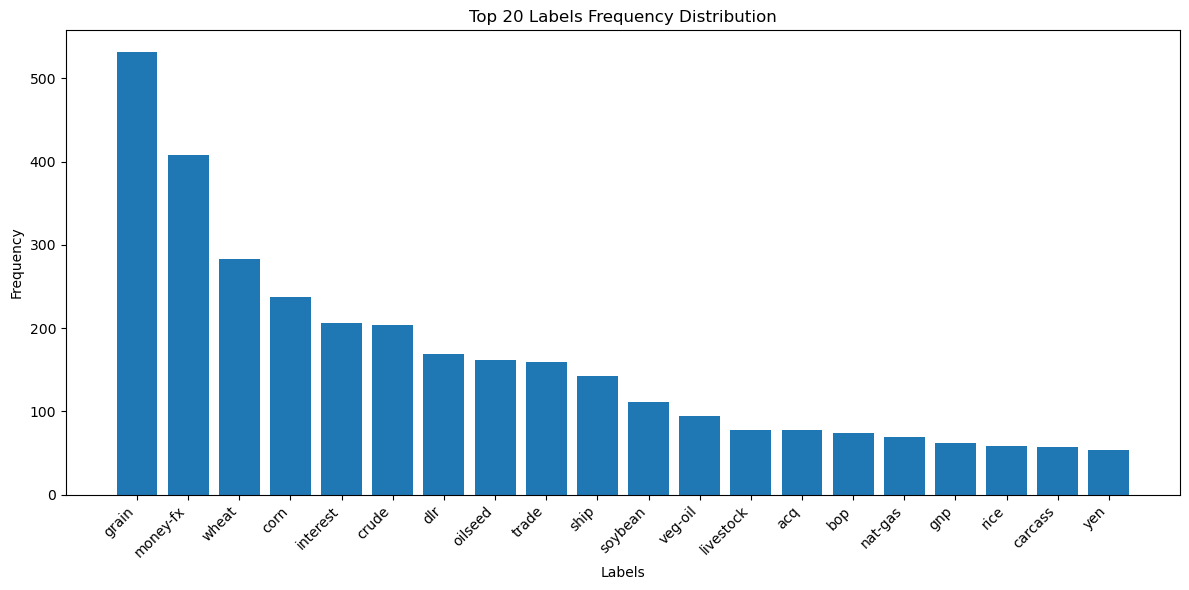

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Load the one-hot encoded labels
y = np.load("y.npy", allow_pickle=True)

# Count occurrences of each label
label_sums = y.sum(axis=0)

# Sort labels by frequency
sorted_indices = np.argsort(label_sums)[::-1]
sorted_label_sums = label_sums[sorted_indices]
sorted_labels = [class_labels[i] for i in sorted_indices]

# Display the counts
print("Label Frequency Distribution:")
for label, count in zip(sorted_labels, sorted_label_sums):
    print(f"{label}: {int(count)}")

# Plot the label frequency distribution
plt.figure(figsize=(12, 6))
plt.bar(sorted_labels[:20], sorted_label_sums[:20])  # Show the top 20 labels for clarity
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Labels Frequency Distribution")
plt.ylabel("Frequency")
plt.xlabel("Labels")
plt.tight_layout()
plt.show()

In [43]:
### Okay, there is definitely a long-tail imbalance for the labels. Where do we go from here? oversample the rare lables? Weighted loss?

In [44]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

# Step 1: Resampling
def resample_data(X, y, label_threshold=50):
    """
    Oversample rare labels in the dataset.
    :param X: Input features
    :param y: One-hot encoded labels
    :param label_threshold: Minimum occurrences to consider a label 'rare'
    :return: Resampled X and y
    """
    # Identify rare labels
    label_counts = np.sum(y, axis=0)
    rare_labels = np.where(label_counts < label_threshold)[0]

    # Oversample data for rare labels
    X_resampled, y_resampled = list(X), list(y)
    for i, (sample, labels) in enumerate(zip(X, y)):
        if any(labels[rare_labels]):
            # Duplicate samples with rare labels
            X_resampled.append(sample)
            y_resampled.append(labels)
    
    return np.array(X_resampled), np.array(y_resampled)

# Apply resampling
X_train_resampled, y_train_resampled = resample_data(X_train, y_train, label_threshold=50)
print(f"Training samples after resampling: {len(X_train_resampled)}")

# Step 2: Weighted Loss Function for Multi-Label
def compute_multi_label_weights(y):
    """
    Compute class weights for multi-label data.
    :param y: One-hot encoded labels
    :return: Dictionary of class weights
    """
    label_sums = np.sum(y, axis=0)  # Total occurrences per label
    total_samples = y.shape[0]
    class_weights = total_samples / (len(label_sums) * label_sums)
    return {i: weight for i, weight in enumerate(class_weights)}

# Calculate weights for multi-label data
class_weights = compute_multi_label_weights(y_train_resampled)
print(f"Class weights: {class_weights}")

# Custom weighted loss function
def weighted_binary_crossentropy(weights):
    """
    Weighted binary crossentropy loss for multi-label classification.
    :param weights: Dictionary of class weights
    :return: Weighted loss function
    """
    def loss_fn(y_true, y_pred):
        binary_crossentropy = K.binary_crossentropy(y_true, y_pred)
        weight_vector = K.constant([weights[i] for i in range(len(weights))])
        weighted_loss = binary_crossentropy * weight_vector
        return K.mean(weighted_loss, axis=-1)
    return loss_fn

# Define the weighted loss
weighted_loss = weighted_binary_crossentropy(class_weights)

# Step 3: Rebuild the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Parameters
embedding_dim = 100  # Match GloVe embeddings
max_sequence_length = 500  # Match preprocessing
num_classes = y_train.shape[1]  # Number of labels

# Create the model
model = Sequential([
    Embedding(input_dim=len(vocabulary) + 1, output_dim=embedding_dim, input_length=max_sequence_length, trainable=True),
    LSTM(128, return_sequences=False),
    Dense(num_classes, activation="sigmoid")
])

model.compile(optimizer="adam", loss=weighted_loss, metrics=["accuracy"])
model.summary()

# Step 4: Train the Model
history = model.fit(
    np.array(X_train_resampled), np.array(y_train_resampled),
    validation_data=(np.array(X_val), np.array(y_val)),
    epochs=10,  
    batch_size=64
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(np.array(X_test), np.array(y_test), verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Training samples after resampling: 8441
Class weights: {0: 0.9353945035460993, 1: 2.244946808510638, 2: 1.0204303675048356, 3: 22.449468085106382, 4: 3.4537643207855973, 5: 6.414133738601824, 6: 2.244946808510638, 7: 1.8707890070921986, 8: 4.0817214700193425, 9: 8.979787234042552, 10: 1.8707890070921986, 11: 4.489893617021276, 12: 2.244946808510638, 13: 11.224734042553191, 14: inf, 15: 0.3620881949210707, 16: 14.96631205673759, 17: 2.993262411347518, 18: 0.7946714366409339, 19: 0.43803840166061236, 20: 0.05512453796220106, 21: 8.979787234042552, 22: 22.449468085106382, 23: 1.662923561859732, 24: 1.7268821603927986, 25: 0.9163048198002606, 26: 0.7126815265113138, 27: 1.0204303675048356, 28: 1.0690222897669706, 29: 22.449468085106382, 30: 11.224734042553191, 31: 0.15617021276595744, 32: 0.2878136933987998, 33: 0.9163048198002606, 34: 1.301418439716312, 35: 3.207066869300912, 36: 14.96631205673759, 37: 1.2134847613571018, 38: 6.414133738601824, 39: 1.0690222897669706, 40: 14.9663120567375

/var/folders/yh/l_t10td97zbcx6stbhn0_w_00000gn/T/ipykernel_22439/1193131174.py:40: RuntimeWarning: divide by zero encountered in divide
  class_weights = total_samples / (len(label_sums) * label_sums)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 55s 398ms/step - accuracy: 0.0097 - loss: nan - val_accuracy: 6.1805e-04 - val_loss: nan
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 47s 354ms/step - accuracy: 0.0111 - loss: nan - val_accuracy: 6.1805e-04 - val_loss: nan
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 50s 381ms/step - accuracy: 0.0110 - loss: nan - val_accuracy: 6.1805e-04 - val_loss: nan
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 50s 379ms/step - accuracy: 0.0107 - loss: nan - val_accuracy: 6.1805e-04 - val_loss: nan
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 348ms/step - accuracy: 0.0092 - loss: nan - val_accuracy: 6.1805e-04 - val_loss: nan
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 50s 378ms/step - accuracy: 0.0109 - loss: nan - val_accuracy: 6.1805e-04 - val_loss: nan
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 52s 395ms/step - accuracy: 0.0125 - loss: nan - val_accuracy: 6.1805e-04 - val_loss: nan
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 60s 453ms/step - accuracy: 0.0137 - loss: nan - val_accur